In [1]:
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
from torch.autograd import Function

/home/hhchung/continual-uda/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_root = "/home/hhchung/data"

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        
        return x
    
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1) # use nll loss
        return output
    
class DomainClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.5)
        self.linear1 = nn.Linear(9216, 128)
        self.linear2 = nn.Linear(128, 2)
    
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = F.log_softmax(x, dim=1)
        return x
    
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

In [21]:
def train(encoder, classifier, device, train_loader, optimizer):
    encoder.train()
    classifier.train()
    
    total_train_loss = 0
    total_size = 0
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = classifier(encoder(data))
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        batch_size = data.shape[0]
        total_train_loss += loss.item() * batch_size
        total_size += batch_size
    
    total_train_loss /= total_size
    return total_train_loss


  
@torch.no_grad()
def test(encoder, classifier, device, test_loader):
    encoder.eval()
    classifier.eval()
    
    total_test_loss = 0  
    total_correct = 0
    total_size = 0
    
    
    for data, target in tqdm(test_loader):
        
        data, target = data.to(device), target.to(device)
        output = classifier(encoder(data))
        loss = F.nll_loss(output, target, reduction='sum')
        total_test_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        total_correct += pred.eq(target.view_as(pred)).sum().item()
        total_size += data.shape[0]
    
    total_test_loss /= total_size
    total_correct /= total_size
    
    return total_test_loss, total_correct

def adapt(encoder, classifier, domain_classifier, device, src_loader, tgt_loader, optimizer, e, epochs, lambda_coef = 10):
    encoder.train()
    classifier.train()
    domain_classifier.train()
    
    len_dataloader = min(len(src_loader), len(tgt_loader))
    src_iter = iter(src_loader)
    tgt_iter = iter(tgt_loader)
    
    total_src_label_loss = 0
    total_src_domain_loss = 0
    total_tgt_domain_loss = 0
    for i in tqdm(range(len_dataloader)):
        # p = float(i + e * len_dataloader) / epochs / len_dataloader
        # alpha = 2. / (1. + np.exp(- lambda_coef * p)) - 1
        alpha = 2
        
        src_data, src_label = src_iter.next()
        src_data, src_label = src_data.to(device), src_label.to(device)
        
        optimizer.zero_grad()
        src_batch_size = src_data.shape[0]
        # print("source batch size", batch_size)
        domain_label = torch.zeros(src_batch_size).long().to(device)
        
        feature = encoder(src_data)
        class_output = classifier(feature)
        domain_output = domain_classifier(ReverseLayerF.apply(feature, alpha))
        
        
        loss_src_label = F.nll_loss(class_output, src_label)
        loss_src_domain = F.nll_loss(domain_output, domain_label)
        

        tgt_data = tgt_iter.next().to(device)
        tgt_batch_size = tgt_data.shape[0]
        # print("target batch size", batch_size)
        domain_label = torch.ones(tgt_batch_size).long().to(device)
        
        domain_output = domain_classifier(ReverseLayerF.apply(encoder(tgt_data), alpha))
        loss_tgt_domain = F.nll_loss(domain_output, domain_label)
        
        # total_batch_size = src_batch_size + tgt_batch_size
        loss = loss_src_label + loss_src_domain + loss_tgt_domain
        loss.backward()
        optimizer.step()
        
        # total_train_loss += loss.item()
        total_src_label_loss += loss_src_label.item()
        total_src_domain_loss += loss_src_domain.item()
        total_tgt_domain_loss += loss_tgt_domain.item()
        # print('src:', loss_src_domain.item(), 'tgt', loss_tgt_domain.item())
    
    # total_train_loss /= len_dataloader
    total_src_label_loss /= len_dataloader
    total_src_domain_loss /= len_dataloader
    total_tgt_domain_loss /= len_dataloader
    
    return total_src_label_loss, total_src_domain_loss, total_tgt_domain_loss

@torch.no_grad()
def adapt_test(encoder, classifier, domain_classifier, device, src_loader, tgt_loader):
    encoder.eval()
    classifier.eval()
    domain_classifier.eval()
    len_dataloader = min(len(src_loader), len(tgt_loader))
    src_iter = iter(src_loader)
    tgt_iter = iter(tgt_loader)
    
    total_src_label_loss = 0
    total_src_domain_loss = 0
    total_tgt_domain_loss = 0
    total_domain_correct = 0
    total_data_num = 0
    
    for i in tqdm(range(len_dataloader)):
        src_data, src_label = src_iter.next()
        src_data, src_label = src_data.to(device), src_label.to(device)
        
        src_batch_size = src_data.shape[0]
        # print("source batch size", batch_size)
        domain_label = torch.zeros(src_batch_size).long().to(device)
        
        feature = encoder(src_data)
        class_output = classifier(feature)
        domain_output = domain_classifier(feature)
        
        
        loss_src_label = F.nll_loss(class_output, src_label)
        loss_src_domain = F.nll_loss(domain_output, domain_label)
        domain_pred = domain_output.argmax(dim=1, keepdim=True)
        total_domain_correct += domain_pred.eq(domain_label.view_as(domain_pred)).sum().item()
        total_data_num += src_batch_size
        
        tgt_data = tgt_iter.next().to(device)
        tgt_batch_size = tgt_data.shape[0]
        # print("target batch size", batch_size)
        domain_label = torch.ones(tgt_batch_size).long().to(device)
        
        domain_output = domain_classifier(encoder(tgt_data))
        loss_tgt_domain = F.nll_loss(domain_output, domain_label)
        domain_pred = domain_output.argmax(dim=1, keepdim=True)
        total_domain_correct += domain_pred.eq(domain_label.view_as(domain_pred)).sum().item()
        total_data_num += tgt_batch_size 
        
        # total_train_loss += loss.item()
        total_src_label_loss += loss_src_label.item()
        total_src_domain_loss += loss_src_domain.item()
        total_tgt_domain_loss += loss_tgt_domain.item()
        # print('src:', loss_src_domain.item(), 'tgt', loss_tgt_domain.item())
    
    # total_train_loss /= len_dataloader
    total_src_label_loss /= len_dataloader
    total_src_domain_loss /= len_dataloader
    total_tgt_domain_loss /= len_dataloader
    total_domain_correct /= total_data_num
    
    return total_src_label_loss, total_src_domain_loss, total_tgt_domain_loss, total_domain_correct
    

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = Encoder().to(device)
classifier = Classifier().to(device)

In [7]:
transform=transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.1307,), (0.3081,))
          ])
train_dataset = datasets.MNIST(data_root, train=True, download=True,
                          transform=transform)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

test_dataset = datasets.MNIST(data_root, train=False,
                       transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False)

epochs = 15
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=0.001)

In [8]:
for e in range(1, epochs + 1):
    train_loss = train(encoder, classifier, device, train_loader, optimizer)
    val_loss, correct = test(encoder, classifier, device, val_loader)
    print(f'Epoch:{e}/{epochs} Train Loss: {round(train_loss, 3)}, Val Loss: {round(val_loss, 3)}, Val Accuracy: {round(correct, 3)}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.83it/s]


Epoch:1/15 Train Loss: 0.583, Val Loss: 0.145, Val Accuracy: 0.957


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.83it/s]


Epoch:2/15 Train Loss: 0.165, Val Loss: 0.076, Val Accuracy: 0.978


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.86it/s]


Epoch:3/15 Train Loss: 0.108, Val Loss: 0.056, Val Accuracy: 0.984


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.84it/s]


Epoch:4/15 Train Loss: 0.083, Val Loss: 0.051, Val Accuracy: 0.985


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.83it/s]


Epoch:5/15 Train Loss: 0.07, Val Loss: 0.045, Val Accuracy: 0.986


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.36it/s]


Epoch:6/15 Train Loss: 0.063, Val Loss: 0.041, Val Accuracy: 0.987


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.85it/s]


Epoch:7/15 Train Loss: 0.052, Val Loss: 0.04, Val Accuracy: 0.988


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.34it/s]


Epoch:8/15 Train Loss: 0.048, Val Loss: 0.037, Val Accuracy: 0.989


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.41it/s]


Epoch:9/15 Train Loss: 0.041, Val Loss: 0.038, Val Accuracy: 0.99


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.76it/s]


Epoch:10/15 Train Loss: 0.039, Val Loss: 0.041, Val Accuracy: 0.988


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.82it/s]


Epoch:11/15 Train Loss: 0.038, Val Loss: 0.036, Val Accuracy: 0.989


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.82it/s]


Epoch:12/15 Train Loss: 0.034, Val Loss: 0.036, Val Accuracy: 0.989


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.80it/s]


Epoch:13/15 Train Loss: 0.031, Val Loss: 0.034, Val Accuracy: 0.99


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.77it/s]


Epoch:14/15 Train Loss: 0.028, Val Loss: 0.037, Val Accuracy: 0.99


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.81it/s]

Epoch:15/15 Train Loss: 0.027, Val Loss: 0.033, Val Accuracy: 0.991


In [9]:
test_loss, test_acc = test(encoder, classifier, device, test_loader)
print(test_loss, test_acc)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.94it/s]

0.03059055371284485 0.9898


In [8]:
class MyRotationTransform:
    """Rotate by one of the given angles."""

    def __init__(self, angle):
        self.angle = angle

    def __call__(self, x):
        return TF.rotate(x, self.angle)


In [10]:
domain_classifier = DomainClassifier().to(device)

## Rotate With 30 Degrees Interval and Evaluate ##

In [22]:
transform=transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.1307,), (0.3081,)),
          MyRotationTransform(30)
          ])

train_dataset_30 = datasets.MNIST(data_root, train=True, download=True,
                          transform=transform)
train_dataset_30 = list(zip(*train_dataset_30))[0]
train_dataset_30, val_dataset_30 = torch.utils.data.random_split(train_dataset_30, [50000, 10000])
test_dataset_30 = datasets.MNIST(data_root, train=False,
                       transform=transform)
# test_dataset_30 = list(zip(*test_dataset))[0]


train_loader_30 = torch.utils.data.DataLoader(train_dataset_30, batch_size=1024, shuffle=True)
val_loader_30 = torch.utils.data.DataLoader(val_dataset_30, batch_size=1024, shuffle=True)
test_loader_30 = torch.utils.data.DataLoader(test_dataset_30, batch_size=1024, shuffle=False)

epochs = 100
encoder_30 = deepcopy(encoder)
classifier_30 = deepcopy(classifier)
domain_classifier_30 = deepcopy(domain_classifier)
optimizer_30 = torch.optim.Adam(list(encoder_30.parameters()) + list(classifier_30.parameters()) + list(domain_classifier_30.parameters()), lr=0.001)

In [18]:
len_dataloader = min(len(train_loader), len(train_loader_30))
epochs = 100
p_list = []
alpha_list = []
for e in range(1, epochs):
    for i in range(len_dataloader):
        p = float(i + e * len_dataloader) / epochs / len_dataloader
        alpha = 2. / (1. + np.exp(-50 * p)) - 1
        p_list.append(p)
        alpha_list.append(alpha)


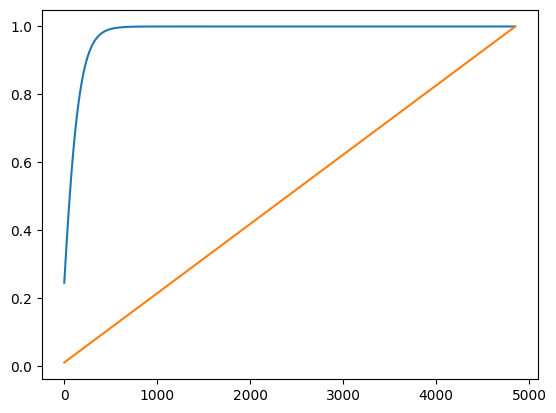

In [19]:
plt.plot(alpha_list)
plt.plot(p_list)
plt.show()

In [23]:
# lambda_coef_list = [10, 5, 3, 1]

# for lambda_coef in lambda_coef_list:
lambda_coef = 50
best_domain_loss = 0
best_encoder_30, best_classifier_30 = None, None
for e in range(1, epochs + 1):
    src_label_loss, src_domain_loss, tgt_domain_loss = adapt(encoder_30, classifier_30, domain_classifier_30, device, train_loader, train_loader_30, optimizer_30, e, epochs, lambda_coef)
    # print(f'Lambda Coef {lambda_coef} Epoch:{e}/{epochs} Source Label Loss:{round(src_label_loss,3)} Source Domain Loss: {round(src_domain_loss,3)} Target Domain Loss: {round(tgt_domain_loss,3)}')
    val_src_label_loss, val_src_domain_loss, val_tgt_domain_loss, val_tgt_domain_acc = adapt_test(encoder_30, classifier_30, domain_classifier_30, device, val_loader, val_loader_30)
    print(f'Lambda Coef {lambda_coef} Epoch:{e}/{epochs} Source Label Loss:{round(src_label_loss,3)} Source Domain Loss: {round(src_domain_loss,3)} Target Domain Loss: {round(tgt_domain_loss,3)} \n Val Source Label Loss:{round(val_src_label_loss,3)} Val Source Domain Loss: {round(val_src_domain_loss,3)} Val Target Domain Loss: {round(val_tgt_domain_loss,3)} Val Target Domain Acc: {round(val_tgt_domain_acc,3)}')
    test_loss, test_acc = test(encoder_30, classifier_30, device, test_loader_30)
    print(f"Test Loss: {test_loss} Test Acc: {test_acc}")
    if val_src_domain_loss + val_tgt_domain_loss > best_domain_loss:
        best_domain_loss = val_src_domain_loss + val_tgt_domain_loss
        best_encoder_30, best_classifier_30 = deepcopy(encoder_30), deepcopy(classifier_30)

encoder_30 = deepcopy(best_encoder_30)
classifier_30 = deepcopy(best_classifier_30)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.42it/s]


Lambda Coef 50 Epoch:1/100 Source Label Loss:0.66 Source Domain Loss: 0.429 Target Domain Loss: 0.398 
 Val Source Label Loss:0.276 Val Source Domain Loss: 0.306 Val Target Domain Loss: 0.3 Val Target Domain Acc: 0.883


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.32it/s]


Test Loss: 1.2144588745117189 Test Acc: 0.5815


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.83it/s]


Lambda Coef 50 Epoch:2/100 Source Label Loss:0.462 Source Domain Loss: 0.383 Target Domain Loss: 0.368 
 Val Source Label Loss:0.345 Val Source Domain Loss: 0.383 Val Target Domain Loss: 0.37 Val Target Domain Acc: 0.853


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.89it/s]


Test Loss: 1.1832311279296874 Test Acc: 0.584


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.36it/s]


Lambda Coef 50 Epoch:3/100 Source Label Loss:0.373 Source Domain Loss: 0.372 Target Domain Loss: 0.381 
 Val Source Label Loss:0.254 Val Source Domain Loss: 0.315 Val Target Domain Loss: 0.45 Val Target Domain Acc: 0.869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.83it/s]


Test Loss: 1.3199503234863281 Test Acc: 0.5451


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.19it/s]


Lambda Coef 50 Epoch:4/100 Source Label Loss:0.331 Source Domain Loss: 0.309 Target Domain Loss: 0.393 
 Val Source Label Loss:0.226 Val Source Domain Loss: 0.228 Val Target Domain Loss: 0.368 Val Target Domain Acc: 0.897


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.36it/s]


Test Loss: 1.117041241455078 Test Acc: 0.6145


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.38it/s]


Lambda Coef 50 Epoch:5/100 Source Label Loss:0.303 Source Domain Loss: 0.319 Target Domain Loss: 0.421 
 Val Source Label Loss:0.195 Val Source Domain Loss: 0.369 Val Target Domain Loss: 0.376 Val Target Domain Acc: 0.858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.55it/s]


Test Loss: 0.9640057434082031 Test Acc: 0.6671


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.41it/s]


Lambda Coef 50 Epoch:6/100 Source Label Loss:0.421 Source Domain Loss: 0.41 Target Domain Loss: 0.489 
 Val Source Label Loss:0.287 Val Source Domain Loss: 0.465 Val Target Domain Loss: 0.553 Val Target Domain Acc: 0.833


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.61it/s]


Test Loss: 1.1354694030761718 Test Acc: 0.6207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.35it/s]


Lambda Coef 50 Epoch:7/100 Source Label Loss:0.359 Source Domain Loss: 0.398 Target Domain Loss: 0.576 
 Val Source Label Loss:0.151 Val Source Domain Loss: 0.29 Val Target Domain Loss: 0.492 Val Target Domain Acc: 0.876


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.97it/s]


Test Loss: 0.9847934020996094 Test Acc: 0.6835


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.50it/s]


Lambda Coef 50 Epoch:8/100 Source Label Loss:0.354 Source Domain Loss: 0.453 Target Domain Loss: 0.526 
 Val Source Label Loss:0.247 Val Source Domain Loss: 0.497 Val Target Domain Loss: 0.463 Val Target Domain Acc: 0.803


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.19it/s]


Test Loss: 0.8441963439941407 Test Acc: 0.7088


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.53it/s]


Lambda Coef 50 Epoch:9/100 Source Label Loss:0.418 Source Domain Loss: 0.503 Target Domain Loss: 0.537 
 Val Source Label Loss:0.172 Val Source Domain Loss: 0.402 Val Target Domain Loss: 0.46 Val Target Domain Acc: 0.858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.35it/s]


Test Loss: 0.8012522064208984 Test Acc: 0.7368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.44it/s]


Lambda Coef 50 Epoch:10/100 Source Label Loss:0.412 Source Domain Loss: 0.535 Target Domain Loss: 0.599 
 Val Source Label Loss:0.187 Val Source Domain Loss: 0.487 Val Target Domain Loss: 0.491 Val Target Domain Acc: 0.829


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.68it/s]


Test Loss: 0.7413713439941406 Test Acc: 0.7592


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.51it/s]


Lambda Coef 50 Epoch:11/100 Source Label Loss:0.382 Source Domain Loss: 0.546 Target Domain Loss: 0.572 
 Val Source Label Loss:0.178 Val Source Domain Loss: 0.538 Val Target Domain Loss: 0.504 Val Target Domain Acc: 0.771


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.69it/s]


Test Loss: 0.7531724365234375 Test Acc: 0.7573


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.77it/s]


Lambda Coef 50 Epoch:12/100 Source Label Loss:0.356 Source Domain Loss: 0.565 Target Domain Loss: 0.549 
 Val Source Label Loss:0.143 Val Source Domain Loss: 0.38 Val Target Domain Loss: 0.444 Val Target Domain Acc: 0.854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.40it/s]


Test Loss: 0.8884314392089844 Test Acc: 0.7211


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.42it/s]


Lambda Coef 50 Epoch:13/100 Source Label Loss:0.322 Source Domain Loss: 0.545 Target Domain Loss: 0.564 
 Val Source Label Loss:0.151 Val Source Domain Loss: 0.442 Val Target Domain Loss: 0.509 Val Target Domain Acc: 0.829


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.07it/s]


Test Loss: 0.6448666198730468 Test Acc: 0.7938


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.69it/s]


Lambda Coef 50 Epoch:14/100 Source Label Loss:0.296 Source Domain Loss: 0.527 Target Domain Loss: 0.576 
 Val Source Label Loss:0.128 Val Source Domain Loss: 0.489 Val Target Domain Loss: 0.468 Val Target Domain Acc: 0.826


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.77it/s]


Test Loss: 0.7229153167724609 Test Acc: 0.7719


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.52it/s]


Lambda Coef 50 Epoch:15/100 Source Label Loss:0.312 Source Domain Loss: 0.629 Target Domain Loss: 0.565 
 Val Source Label Loss:0.134 Val Source Domain Loss: 0.511 Val Target Domain Loss: 0.541 Val Target Domain Acc: 0.775


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.07it/s]


Test Loss: 0.6742589141845703 Test Acc: 0.7809


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.07it/s]


Lambda Coef 50 Epoch:16/100 Source Label Loss:0.301 Source Domain Loss: 0.63 Target Domain Loss: 0.572 
 Val Source Label Loss:0.123 Val Source Domain Loss: 0.541 Val Target Domain Loss: 0.475 Val Target Domain Acc: 0.777


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.27it/s]


Test Loss: 0.6260665313720704 Test Acc: 0.7997


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.24it/s]


Lambda Coef 50 Epoch:17/100 Source Label Loss:0.315 Source Domain Loss: 0.6 Target Domain Loss: 0.583 
 Val Source Label Loss:0.156 Val Source Domain Loss: 0.63 Val Target Domain Loss: 0.49 Val Target Domain Acc: 0.73


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.50it/s]


Test Loss: 0.6723323364257813 Test Acc: 0.7778


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.40it/s]


Lambda Coef 50 Epoch:18/100 Source Label Loss:0.356 Source Domain Loss: 0.667 Target Domain Loss: 0.596 
 Val Source Label Loss:0.144 Val Source Domain Loss: 0.559 Val Target Domain Loss: 0.517 Val Target Domain Acc: 0.764


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.37it/s]


Test Loss: 0.6936962158203125 Test Acc: 0.7771


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.64it/s]


Lambda Coef 50 Epoch:19/100 Source Label Loss:0.31 Source Domain Loss: 0.585 Target Domain Loss: 0.603 
 Val Source Label Loss:0.146 Val Source Domain Loss: 0.578 Val Target Domain Loss: 0.54 Val Target Domain Acc: 0.768


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.12it/s]


Test Loss: 0.643083657836914 Test Acc: 0.7925


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.63it/s]


Lambda Coef 50 Epoch:20/100 Source Label Loss:0.344 Source Domain Loss: 0.65 Target Domain Loss: 0.605 
 Val Source Label Loss:0.155 Val Source Domain Loss: 0.694 Val Target Domain Loss: 0.504 Val Target Domain Acc: 0.693


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.93it/s]


Test Loss: 0.6155142822265625 Test Acc: 0.7926


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.46it/s]


Lambda Coef 50 Epoch:21/100 Source Label Loss:0.325 Source Domain Loss: 0.63 Target Domain Loss: 0.593 
 Val Source Label Loss:0.121 Val Source Domain Loss: 0.49 Val Target Domain Loss: 0.53 Val Target Domain Acc: 0.791


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.08it/s]


Test Loss: 0.6175381591796875 Test Acc: 0.8024


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.48it/s]


Lambda Coef 50 Epoch:22/100 Source Label Loss:0.326 Source Domain Loss: 0.624 Target Domain Loss: 0.595 
 Val Source Label Loss:0.156 Val Source Domain Loss: 0.725 Val Target Domain Loss: 0.478 Val Target Domain Acc: 0.677


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.60it/s]


Test Loss: 0.6603526885986328 Test Acc: 0.7918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.66it/s]


Lambda Coef 50 Epoch:23/100 Source Label Loss:0.32 Source Domain Loss: 0.619 Target Domain Loss: 0.598 
 Val Source Label Loss:0.127 Val Source Domain Loss: 0.586 Val Target Domain Loss: 0.492 Val Target Domain Acc: 0.756


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.17it/s]


Test Loss: 0.6626586334228516 Test Acc: 0.7945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.61it/s]


Lambda Coef 50 Epoch:24/100 Source Label Loss:0.313 Source Domain Loss: 0.641 Target Domain Loss: 0.596 
 Val Source Label Loss:0.143 Val Source Domain Loss: 0.65 Val Target Domain Loss: 0.522 Val Target Domain Acc: 0.743


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.45it/s]


Test Loss: 0.6453335876464844 Test Acc: 0.7937


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.65it/s]


Lambda Coef 50 Epoch:25/100 Source Label Loss:0.301 Source Domain Loss: 0.591 Target Domain Loss: 0.609 
 Val Source Label Loss:0.124 Val Source Domain Loss: 0.522 Val Target Domain Loss: 0.506 Val Target Domain Acc: 0.793


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.25it/s]


Test Loss: 0.5723252624511719 Test Acc: 0.8223


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.33it/s]


Lambda Coef 50 Epoch:26/100 Source Label Loss:0.303 Source Domain Loss: 0.603 Target Domain Loss: 0.596 
 Val Source Label Loss:0.126 Val Source Domain Loss: 0.61 Val Target Domain Loss: 0.481 Val Target Domain Acc: 0.741


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.92it/s]


Test Loss: 0.6284789947509766 Test Acc: 0.7957


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.39it/s]


Lambda Coef 50 Epoch:27/100 Source Label Loss:0.305 Source Domain Loss: 0.653 Target Domain Loss: 0.589 
 Val Source Label Loss:0.122 Val Source Domain Loss: 0.699 Val Target Domain Loss: 0.479 Val Target Domain Acc: 0.698


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.35it/s]


Test Loss: 0.6898977355957031 Test Acc: 0.779


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.23it/s]


Lambda Coef 50 Epoch:28/100 Source Label Loss:0.309 Source Domain Loss: 0.629 Target Domain Loss: 0.587 
 Val Source Label Loss:0.122 Val Source Domain Loss: 0.579 Val Target Domain Loss: 0.511 Val Target Domain Acc: 0.753


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.10it/s]


Test Loss: 0.7111966186523437 Test Acc: 0.7801


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.38it/s]


Lambda Coef 50 Epoch:29/100 Source Label Loss:0.324 Source Domain Loss: 0.647 Target Domain Loss: 0.599 
 Val Source Label Loss:0.133 Val Source Domain Loss: 0.677 Val Target Domain Loss: 0.531 Val Target Domain Acc: 0.684


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.54it/s]


Test Loss: 0.706269174194336 Test Acc: 0.7803


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.65it/s]


Lambda Coef 50 Epoch:30/100 Source Label Loss:0.303 Source Domain Loss: 0.62 Target Domain Loss: 0.612 
 Val Source Label Loss:0.127 Val Source Domain Loss: 0.562 Val Target Domain Loss: 0.526 Val Target Domain Acc: 0.784


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.19it/s]


Test Loss: 0.5907698944091797 Test Acc: 0.8141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.97it/s]


Lambda Coef 50 Epoch:31/100 Source Label Loss:0.316 Source Domain Loss: 0.62 Target Domain Loss: 0.613 
 Val Source Label Loss:0.15 Val Source Domain Loss: 0.606 Val Target Domain Loss: 0.544 Val Target Domain Acc: 0.745


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.12it/s]


Test Loss: 0.585218408203125 Test Acc: 0.8195


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.23it/s]


Lambda Coef 50 Epoch:32/100 Source Label Loss:0.337 Source Domain Loss: 0.65 Target Domain Loss: 0.618 
 Val Source Label Loss:0.13 Val Source Domain Loss: 0.713 Val Target Domain Loss: 0.504 Val Target Domain Acc: 0.667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.87it/s]


Test Loss: 0.6615972534179687 Test Acc: 0.7958


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.45it/s]


Lambda Coef 50 Epoch:33/100 Source Label Loss:0.326 Source Domain Loss: 0.632 Target Domain Loss: 0.622 
 Val Source Label Loss:0.125 Val Source Domain Loss: 0.673 Val Target Domain Loss: 0.504 Val Target Domain Acc: 0.707


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.35it/s]


Test Loss: 0.6336332855224609 Test Acc: 0.7992


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.58it/s]


Lambda Coef 50 Epoch:34/100 Source Label Loss:0.326 Source Domain Loss: 0.626 Target Domain Loss: 0.607 
 Val Source Label Loss:0.122 Val Source Domain Loss: 0.62 Val Target Domain Loss: 0.503 Val Target Domain Acc: 0.741


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.20it/s]


Test Loss: 0.6402396270751953 Test Acc: 0.7995


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.42it/s]


Lambda Coef 50 Epoch:35/100 Source Label Loss:0.301 Source Domain Loss: 0.612 Target Domain Loss: 0.611 
 Val Source Label Loss:0.123 Val Source Domain Loss: 0.688 Val Target Domain Loss: 0.498 Val Target Domain Acc: 0.705


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.11it/s]


Test Loss: 0.5690173461914062 Test Acc: 0.8226


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.41it/s]


Lambda Coef 50 Epoch:36/100 Source Label Loss:0.328 Source Domain Loss: 0.681 Target Domain Loss: 0.607 
 Val Source Label Loss:0.145 Val Source Domain Loss: 0.582 Val Target Domain Loss: 0.573 Val Target Domain Acc: 0.776


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.55it/s]


Test Loss: 0.5997941375732422 Test Acc: 0.8083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.68it/s]


Lambda Coef 50 Epoch:37/100 Source Label Loss:0.287 Source Domain Loss: 0.577 Target Domain Loss: 0.616 
 Val Source Label Loss:0.117 Val Source Domain Loss: 0.587 Val Target Domain Loss: 0.499 Val Target Domain Acc: 0.771


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.19it/s]


Test Loss: 0.6823770660400391 Test Acc: 0.7977


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.59it/s]


Lambda Coef 50 Epoch:38/100 Source Label Loss:0.332 Source Domain Loss: 0.652 Target Domain Loss: 0.607 
 Val Source Label Loss:0.135 Val Source Domain Loss: 0.718 Val Target Domain Loss: 0.506 Val Target Domain Acc: 0.677


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.83it/s]


Test Loss: 0.6236769989013672 Test Acc: 0.8016


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.38it/s]


Lambda Coef 50 Epoch:39/100 Source Label Loss:0.326 Source Domain Loss: 0.657 Target Domain Loss: 0.615 
 Val Source Label Loss:0.133 Val Source Domain Loss: 0.58 Val Target Domain Loss: 0.551 Val Target Domain Acc: 0.761


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.10it/s]


Test Loss: 0.6752956756591797 Test Acc: 0.791


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.15it/s]


Lambda Coef 50 Epoch:40/100 Source Label Loss:0.314 Source Domain Loss: 0.59 Target Domain Loss: 0.617 
 Val Source Label Loss:0.127 Val Source Domain Loss: 0.627 Val Target Domain Loss: 0.517 Val Target Domain Acc: 0.738


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.37it/s]


Test Loss: 0.7367618560791016 Test Acc: 0.7744


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.13it/s]


Lambda Coef 50 Epoch:41/100 Source Label Loss:0.336 Source Domain Loss: 0.645 Target Domain Loss: 0.609 
 Val Source Label Loss:0.141 Val Source Domain Loss: 0.642 Val Target Domain Loss: 0.52 Val Target Domain Acc: 0.729


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.89it/s]


Test Loss: 0.6705428344726563 Test Acc: 0.7849


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.97it/s]


Lambda Coef 50 Epoch:42/100 Source Label Loss:0.349 Source Domain Loss: 0.644 Target Domain Loss: 0.623 
 Val Source Label Loss:0.154 Val Source Domain Loss: 0.634 Val Target Domain Loss: 0.537 Val Target Domain Acc: 0.717


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.92it/s]


Test Loss: 0.7549358795166016 Test Acc: 0.7666


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.99it/s]


Lambda Coef 50 Epoch:43/100 Source Label Loss:0.367 Source Domain Loss: 0.685 Target Domain Loss: 0.616 
 Val Source Label Loss:0.161 Val Source Domain Loss: 0.776 Val Target Domain Loss: 0.519 Val Target Domain Acc: 0.632


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.91it/s]


Test Loss: 0.7226871856689453 Test Acc: 0.7697


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.01it/s]


Lambda Coef 50 Epoch:44/100 Source Label Loss:0.314 Source Domain Loss: 0.589 Target Domain Loss: 0.628 
 Val Source Label Loss:0.112 Val Source Domain Loss: 0.485 Val Target Domain Loss: 0.556 Val Target Domain Acc: 0.8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.87it/s]


Test Loss: 0.7236870910644532 Test Acc: 0.7869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.97it/s]


Lambda Coef 50 Epoch:45/100 Source Label Loss:0.318 Source Domain Loss: 0.573 Target Domain Loss: 0.621 
 Val Source Label Loss:0.151 Val Source Domain Loss: 0.734 Val Target Domain Loss: 0.48 Val Target Domain Acc: 0.673


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.78it/s]


Test Loss: 0.7401124847412109 Test Acc: 0.7689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.83it/s]


Lambda Coef 50 Epoch:46/100 Source Label Loss:0.333 Source Domain Loss: 0.688 Target Domain Loss: 0.601 
 Val Source Label Loss:0.127 Val Source Domain Loss: 0.714 Val Target Domain Loss: 0.518 Val Target Domain Acc: 0.67


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.78it/s]


Test Loss: 0.6993886901855468 Test Acc: 0.7823


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.73it/s]


Lambda Coef 50 Epoch:47/100 Source Label Loss:0.278 Source Domain Loss: 0.619 Target Domain Loss: 0.601 
 Val Source Label Loss:0.117 Val Source Domain Loss: 0.499 Val Target Domain Loss: 0.54 Val Target Domain Acc: 0.799


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.77it/s]


Test Loss: 0.7301947082519531 Test Acc: 0.7773


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.21it/s]


Lambda Coef 50 Epoch:48/100 Source Label Loss:0.288 Source Domain Loss: 0.588 Target Domain Loss: 0.606 
 Val Source Label Loss:0.125 Val Source Domain Loss: 0.624 Val Target Domain Loss: 0.538 Val Target Domain Acc: 0.73


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.96it/s]


Test Loss: 0.7119565734863281 Test Acc: 0.7833


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.10it/s]


Lambda Coef 50 Epoch:49/100 Source Label Loss:0.323 Source Domain Loss: 0.645 Target Domain Loss: 0.616 
 Val Source Label Loss:0.128 Val Source Domain Loss: 0.586 Val Target Domain Loss: 0.557 Val Target Domain Acc: 0.765


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.95it/s]


Test Loss: 0.6918093383789062 Test Acc: 0.795


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.24it/s]


Lambda Coef 50 Epoch:50/100 Source Label Loss:0.309 Source Domain Loss: 0.638 Target Domain Loss: 0.618 
 Val Source Label Loss:0.133 Val Source Domain Loss: 0.648 Val Target Domain Loss: 0.559 Val Target Domain Acc: 0.721


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.93it/s]


Test Loss: 0.6474427337646484 Test Acc: 0.804


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.26it/s]


Lambda Coef 50 Epoch:51/100 Source Label Loss:0.3 Source Domain Loss: 0.668 Target Domain Loss: 0.611 
 Val Source Label Loss:0.13 Val Source Domain Loss: 0.68 Val Target Domain Loss: 0.522 Val Target Domain Acc: 0.706


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.92it/s]


Test Loss: 0.6139600921630859 Test Acc: 0.8106


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.95it/s]


Lambda Coef 50 Epoch:52/100 Source Label Loss:0.304 Source Domain Loss: 0.622 Target Domain Loss: 0.618 
 Val Source Label Loss:0.118 Val Source Domain Loss: 0.583 Val Target Domain Loss: 0.513 Val Target Domain Acc: 0.756


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.81it/s]


Test Loss: 0.7317953765869141 Test Acc: 0.7858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.21it/s]


Lambda Coef 50 Epoch:53/100 Source Label Loss:0.314 Source Domain Loss: 0.624 Target Domain Loss: 0.625 
 Val Source Label Loss:0.129 Val Source Domain Loss: 0.67 Val Target Domain Loss: 0.55 Val Target Domain Acc: 0.698


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.94it/s]


Test Loss: 0.5800357299804687 Test Acc: 0.8254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.30it/s]


Lambda Coef 50 Epoch:54/100 Source Label Loss:0.297 Source Domain Loss: 0.694 Target Domain Loss: 0.59 
 Val Source Label Loss:0.126 Val Source Domain Loss: 0.637 Val Target Domain Loss: 0.557 Val Target Domain Acc: 0.727


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.68it/s]


Test Loss: 0.5992022613525391 Test Acc: 0.8205


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00, 10.00it/s]


Lambda Coef 50 Epoch:55/100 Source Label Loss:0.272 Source Domain Loss: 0.614 Target Domain Loss: 0.621 
 Val Source Label Loss:0.117 Val Source Domain Loss: 0.547 Val Target Domain Loss: 0.572 Val Target Domain Acc: 0.764


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.95it/s]


Test Loss: 0.7230026275634766 Test Acc: 0.7902


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.04it/s]


Lambda Coef 50 Epoch:56/100 Source Label Loss:0.306 Source Domain Loss: 0.658 Target Domain Loss: 0.61 
 Val Source Label Loss:0.117 Val Source Domain Loss: 0.618 Val Target Domain Loss: 0.54 Val Target Domain Acc: 0.734


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.79it/s]


Test Loss: 0.7371974365234375 Test Acc: 0.7833


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.58it/s]


Lambda Coef 50 Epoch:57/100 Source Label Loss:0.321 Source Domain Loss: 0.664 Target Domain Loss: 0.621 
 Val Source Label Loss:0.109 Val Source Domain Loss: 0.67 Val Target Domain Loss: 0.545 Val Target Domain Acc: 0.701


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.74it/s]


Test Loss: 0.7834649963378906 Test Acc: 0.7788


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.06it/s]


Lambda Coef 50 Epoch:58/100 Source Label Loss:0.291 Source Domain Loss: 0.646 Target Domain Loss: 0.63 
 Val Source Label Loss:0.116 Val Source Domain Loss: 0.584 Val Target Domain Loss: 0.587 Val Target Domain Acc: 0.766


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.94it/s]


Test Loss: 0.6987428985595703 Test Acc: 0.7859


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.96it/s]


Lambda Coef 50 Epoch:59/100 Source Label Loss:0.284 Source Domain Loss: 0.648 Target Domain Loss: 0.628 
 Val Source Label Loss:0.136 Val Source Domain Loss: 0.638 Val Target Domain Loss: 0.578 Val Target Domain Acc: 0.719


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.80it/s]


Test Loss: 0.7774589080810547 Test Acc: 0.7687


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.04it/s]


Lambda Coef 50 Epoch:60/100 Source Label Loss:0.296 Source Domain Loss: 0.649 Target Domain Loss: 0.634 
 Val Source Label Loss:0.12 Val Source Domain Loss: 0.579 Val Target Domain Loss: 0.588 Val Target Domain Acc: 0.762


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.92it/s]


Test Loss: 1.04147158203125 Test Acc: 0.7682


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.00it/s]


Lambda Coef 50 Epoch:61/100 Source Label Loss:0.279 Source Domain Loss: 0.593 Target Domain Loss: 0.647 
 Val Source Label Loss:0.132 Val Source Domain Loss: 0.612 Val Target Domain Loss: 0.559 Val Target Domain Acc: 0.744


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.92it/s]


Test Loss: 0.7270485534667969 Test Acc: 0.7879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.71it/s]


Lambda Coef 50 Epoch:62/100 Source Label Loss:0.303 Source Domain Loss: 0.673 Target Domain Loss: 0.615 
 Val Source Label Loss:0.114 Val Source Domain Loss: 0.671 Val Target Domain Loss: 0.532 Val Target Domain Acc: 0.704


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.88it/s]


Test Loss: 0.6757459045410156 Test Acc: 0.7989


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00, 10.00it/s]


Lambda Coef 50 Epoch:63/100 Source Label Loss:0.279 Source Domain Loss: 0.604 Target Domain Loss: 0.618 
 Val Source Label Loss:0.103 Val Source Domain Loss: 0.535 Val Target Domain Loss: 0.547 Val Target Domain Acc: 0.783


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.88it/s]


Test Loss: 0.7717284790039063 Test Acc: 0.7813


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.03it/s]


Lambda Coef 50 Epoch:64/100 Source Label Loss:0.288 Source Domain Loss: 0.656 Target Domain Loss: 0.613 
 Val Source Label Loss:0.127 Val Source Domain Loss: 0.74 Val Target Domain Loss: 0.553 Val Target Domain Acc: 0.644


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.87it/s]


Test Loss: 0.735376937866211 Test Acc: 0.7836


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.99it/s]


Lambda Coef 50 Epoch:65/100 Source Label Loss:0.287 Source Domain Loss: 0.689 Target Domain Loss: 0.614 
 Val Source Label Loss:0.12 Val Source Domain Loss: 0.562 Val Target Domain Loss: 0.579 Val Target Domain Acc: 0.775


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.62it/s]


Test Loss: 0.7743364868164062 Test Acc: 0.7932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.06it/s]


Lambda Coef 50 Epoch:66/100 Source Label Loss:0.245 Source Domain Loss: 0.585 Target Domain Loss: 0.625 
 Val Source Label Loss:0.111 Val Source Domain Loss: 0.574 Val Target Domain Loss: 0.555 Val Target Domain Acc: 0.774


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.92it/s]


Test Loss: 0.7321693237304687 Test Acc: 0.784


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.73it/s]


Lambda Coef 50 Epoch:67/100 Source Label Loss:0.261 Source Domain Loss: 0.679 Target Domain Loss: 0.613 
 Val Source Label Loss:0.111 Val Source Domain Loss: 0.766 Val Target Domain Loss: 0.542 Val Target Domain Acc: 0.616


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.78it/s]


Test Loss: 0.6962443939208984 Test Acc: 0.7914


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.02it/s]


Lambda Coef 50 Epoch:68/100 Source Label Loss:0.25 Source Domain Loss: 0.632 Target Domain Loss: 0.632 
 Val Source Label Loss:0.102 Val Source Domain Loss: 0.517 Val Target Domain Loss: 0.564 Val Target Domain Acc: 0.793


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.91it/s]


Test Loss: 0.6267448852539063 Test Acc: 0.8172


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.99it/s]


Lambda Coef 50 Epoch:69/100 Source Label Loss:0.255 Source Domain Loss: 0.591 Target Domain Loss: 0.623 
 Val Source Label Loss:0.107 Val Source Domain Loss: 0.656 Val Target Domain Loss: 0.522 Val Target Domain Acc: 0.699


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.92it/s]


Test Loss: 0.7643140869140626 Test Acc: 0.7909


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.00it/s]


Lambda Coef 50 Epoch:70/100 Source Label Loss:0.266 Source Domain Loss: 0.634 Target Domain Loss: 0.623 
 Val Source Label Loss:0.112 Val Source Domain Loss: 0.613 Val Target Domain Loss: 0.552 Val Target Domain Acc: 0.744


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.88it/s]


Test Loss: 0.9962297821044922 Test Acc: 0.7648


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.89it/s]


Lambda Coef 50 Epoch:71/100 Source Label Loss:0.282 Source Domain Loss: 0.651 Target Domain Loss: 0.621 
 Val Source Label Loss:0.109 Val Source Domain Loss: 0.647 Val Target Domain Loss: 0.551 Val Target Domain Acc: 0.716


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.88it/s]


Test Loss: 0.6547533813476563 Test Acc: 0.7977


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.93it/s]


Lambda Coef 50 Epoch:72/100 Source Label Loss:0.288 Source Domain Loss: 0.655 Target Domain Loss: 0.624 
 Val Source Label Loss:0.121 Val Source Domain Loss: 0.587 Val Target Domain Loss: 0.607 Val Target Domain Acc: 0.733


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.87it/s]


Test Loss: 0.693108169555664 Test Acc: 0.7851


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.96it/s]


Lambda Coef 50 Epoch:73/100 Source Label Loss:0.29 Source Domain Loss: 0.647 Target Domain Loss: 0.636 
 Val Source Label Loss:0.115 Val Source Domain Loss: 0.566 Val Target Domain Loss: 0.585 Val Target Domain Acc: 0.764


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.91it/s]


Test Loss: 0.8657640045166015 Test Acc: 0.7678


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.68it/s]


Lambda Coef 50 Epoch:74/100 Source Label Loss:0.282 Source Domain Loss: 0.633 Target Domain Loss: 0.634 
 Val Source Label Loss:0.119 Val Source Domain Loss: 0.62 Val Target Domain Loss: 0.567 Val Target Domain Acc: 0.731


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.84it/s]


Test Loss: 0.7409214874267578 Test Acc: 0.786


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.91it/s]


Lambda Coef 50 Epoch:75/100 Source Label Loss:0.296 Source Domain Loss: 0.666 Target Domain Loss: 0.625 
 Val Source Label Loss:0.125 Val Source Domain Loss: 0.656 Val Target Domain Loss: 0.559 Val Target Domain Acc: 0.7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.90it/s]


Test Loss: 0.6601914123535156 Test Acc: 0.7973


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.01it/s]


Lambda Coef 50 Epoch:76/100 Source Label Loss:0.276 Source Domain Loss: 0.61 Target Domain Loss: 0.639 
 Val Source Label Loss:0.118 Val Source Domain Loss: 0.559 Val Target Domain Loss: 0.579 Val Target Domain Acc: 0.759


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.93it/s]


Test Loss: 0.7726389312744141 Test Acc: 0.7824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.07it/s]


Lambda Coef 50 Epoch:77/100 Source Label Loss:0.307 Source Domain Loss: 0.66 Target Domain Loss: 0.627 
 Val Source Label Loss:0.125 Val Source Domain Loss: 0.717 Val Target Domain Loss: 0.542 Val Target Domain Acc: 0.658


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.69it/s]


Test Loss: 0.8205834930419922 Test Acc: 0.7528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.00it/s]


Lambda Coef 50 Epoch:78/100 Source Label Loss:0.281 Source Domain Loss: 0.645 Target Domain Loss: 0.631 
 Val Source Label Loss:0.113 Val Source Domain Loss: 0.666 Val Target Domain Loss: 0.544 Val Target Domain Acc: 0.71


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.86it/s]


Test Loss: 0.8004682189941407 Test Acc: 0.7788


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.87it/s]


Lambda Coef 50 Epoch:79/100 Source Label Loss:0.28 Source Domain Loss: 0.637 Target Domain Loss: 0.629 
 Val Source Label Loss:0.103 Val Source Domain Loss: 0.6 Val Target Domain Loss: 0.54 Val Target Domain Acc: 0.762


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.79it/s]


Test Loss: 0.6963964752197266 Test Acc: 0.7916


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.02it/s]


Lambda Coef 50 Epoch:80/100 Source Label Loss:0.263 Source Domain Loss: 0.595 Target Domain Loss: 0.618 
 Val Source Label Loss:0.119 Val Source Domain Loss: 0.67 Val Target Domain Loss: 0.516 Val Target Domain Acc: 0.695


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.93it/s]


Test Loss: 0.8814361022949219 Test Acc: 0.7745


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.02it/s]


Lambda Coef 50 Epoch:81/100 Source Label Loss:0.294 Source Domain Loss: 0.686 Target Domain Loss: 0.618 
 Val Source Label Loss:0.125 Val Source Domain Loss: 0.648 Val Target Domain Loss: 0.564 Val Target Domain Acc: 0.714


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.83it/s]


Test Loss: 1.8426980590820312 Test Acc: 0.6812


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.03it/s]


Lambda Coef 50 Epoch:82/100 Source Label Loss:0.281 Source Domain Loss: 0.695 Target Domain Loss: 0.613 
 Val Source Label Loss:0.118 Val Source Domain Loss: 0.558 Val Target Domain Loss: 0.615 Val Target Domain Acc: 0.756


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.96it/s]


Test Loss: 0.7722994812011719 Test Acc: 0.7742


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.99it/s]


Lambda Coef 50 Epoch:83/100 Source Label Loss:0.242 Source Domain Loss: 0.506 Target Domain Loss: 0.638 
 Val Source Label Loss:0.109 Val Source Domain Loss: 0.483 Val Target Domain Loss: 0.539 Val Target Domain Acc: 0.798


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.89it/s]


Test Loss: 0.8631981628417968 Test Acc: 0.765


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.01it/s]


Lambda Coef 50 Epoch:84/100 Source Label Loss:0.281 Source Domain Loss: 0.663 Target Domain Loss: 0.6 
 Val Source Label Loss:0.114 Val Source Domain Loss: 0.795 Val Target Domain Loss: 0.514 Val Target Domain Acc: 0.606


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.91it/s]


Test Loss: 0.9535655090332031 Test Acc: 0.7444


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.99it/s]


Lambda Coef 50 Epoch:85/100 Source Label Loss:0.284 Source Domain Loss: 0.725 Target Domain Loss: 0.596 
 Val Source Label Loss:0.106 Val Source Domain Loss: 0.65 Val Target Domain Loss: 0.564 Val Target Domain Acc: 0.717


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.93it/s]


Test Loss: 0.8825072296142578 Test Acc: 0.7539


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.97it/s]


Lambda Coef 50 Epoch:86/100 Source Label Loss:0.254 Source Domain Loss: 0.635 Target Domain Loss: 0.633 
 Val Source Label Loss:0.11 Val Source Domain Loss: 0.559 Val Target Domain Loss: 0.604 Val Target Domain Acc: 0.755


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.94it/s]


Test Loss: 0.8180950103759765 Test Acc: 0.7638


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.99it/s]


Lambda Coef 50 Epoch:87/100 Source Label Loss:0.277 Source Domain Loss: 0.64 Target Domain Loss: 0.638 
 Val Source Label Loss:0.116 Val Source Domain Loss: 0.656 Val Target Domain Loss: 0.558 Val Target Domain Acc: 0.711


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.65it/s]


Test Loss: 0.8736198120117188 Test Acc: 0.7633


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.97it/s]


Lambda Coef 50 Epoch:88/100 Source Label Loss:0.286 Source Domain Loss: 0.646 Target Domain Loss: 0.644 
 Val Source Label Loss:0.119 Val Source Domain Loss: 0.582 Val Target Domain Loss: 0.605 Val Target Domain Acc: 0.748


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.92it/s]


Test Loss: 0.8540798767089843 Test Acc: 0.7807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.74it/s]


Lambda Coef 50 Epoch:89/100 Source Label Loss:0.27 Source Domain Loss: 0.621 Target Domain Loss: 0.654 
 Val Source Label Loss:0.104 Val Source Domain Loss: 0.591 Val Target Domain Loss: 0.585 Val Target Domain Acc: 0.754


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.82it/s]


Test Loss: 1.0775003845214843 Test Acc: 0.7648


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.97it/s]


Lambda Coef 50 Epoch:90/100 Source Label Loss:0.287 Source Domain Loss: 0.666 Target Domain Loss: 0.625 
 Val Source Label Loss:0.116 Val Source Domain Loss: 0.686 Val Target Domain Loss: 0.555 Val Target Domain Acc: 0.667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.95it/s]


Test Loss: 0.7426457458496094 Test Acc: 0.7849


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00, 10.00it/s]


Lambda Coef 50 Epoch:91/100 Source Label Loss:0.287 Source Domain Loss: 0.671 Target Domain Loss: 0.626 
 Val Source Label Loss:0.122 Val Source Domain Loss: 0.603 Val Target Domain Loss: 0.608 Val Target Domain Acc: 0.718


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.90it/s]


Test Loss: 0.7368692840576172 Test Acc: 0.7844


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.01it/s]


Lambda Coef 50 Epoch:92/100 Source Label Loss:0.283 Source Domain Loss: 0.65 Target Domain Loss: 0.643 
 Val Source Label Loss:0.117 Val Source Domain Loss: 0.616 Val Target Domain Loss: 0.603 Val Target Domain Acc: 0.718


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.92it/s]


Test Loss: 0.8797740051269531 Test Acc: 0.7675


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.02it/s]


Lambda Coef 50 Epoch:93/100 Source Label Loss:0.283 Source Domain Loss: 0.661 Target Domain Loss: 0.642 
 Val Source Label Loss:0.114 Val Source Domain Loss: 0.632 Val Target Domain Loss: 0.607 Val Target Domain Acc: 0.687


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.89it/s]


Test Loss: 0.8563679138183594 Test Acc: 0.7717


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.90it/s]


Lambda Coef 50 Epoch:94/100 Source Label Loss:0.277 Source Domain Loss: 0.643 Target Domain Loss: 0.644 
 Val Source Label Loss:0.11 Val Source Domain Loss: 0.548 Val Target Domain Loss: 0.618 Val Target Domain Acc: 0.758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.88it/s]


Test Loss: 0.9311540557861329 Test Acc: 0.7595


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.71it/s]


Lambda Coef 50 Epoch:95/100 Source Label Loss:0.285 Source Domain Loss: 0.648 Target Domain Loss: 0.641 
 Val Source Label Loss:0.118 Val Source Domain Loss: 0.694 Val Target Domain Loss: 0.574 Val Target Domain Acc: 0.65


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.79it/s]


Test Loss: 1.0566432983398437 Test Acc: 0.7297


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.74it/s]


Lambda Coef 50 Epoch:96/100 Source Label Loss:0.28 Source Domain Loss: 0.659 Target Domain Loss: 0.633 
 Val Source Label Loss:0.109 Val Source Domain Loss: 0.618 Val Target Domain Loss: 0.589 Val Target Domain Acc: 0.705


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.79it/s]


Test Loss: 0.961432470703125 Test Acc: 0.7488


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.99it/s]


Lambda Coef 50 Epoch:97/100 Source Label Loss:0.28 Source Domain Loss: 0.659 Target Domain Loss: 0.639 
 Val Source Label Loss:0.118 Val Source Domain Loss: 0.691 Val Target Domain Loss: 0.565 Val Target Domain Acc: 0.684


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.93it/s]


Test Loss: 0.9691582885742187 Test Acc: 0.7563


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.99it/s]


Lambda Coef 50 Epoch:98/100 Source Label Loss:0.262 Source Domain Loss: 0.604 Target Domain Loss: 0.652 
 Val Source Label Loss:0.114 Val Source Domain Loss: 0.585 Val Target Domain Loss: 0.581 Val Target Domain Acc: 0.755


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.54it/s]


Test Loss: 1.4339059692382812 Test Acc: 0.7345


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.99it/s]


Lambda Coef 50 Epoch:99/100 Source Label Loss:0.269 Source Domain Loss: 0.647 Target Domain Loss: 0.639 
 Val Source Label Loss:0.123 Val Source Domain Loss: 0.731 Val Target Domain Loss: 0.562 Val Target Domain Acc: 0.639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.91it/s]


Test Loss: 0.8269040374755859 Test Acc: 0.7693


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00, 10.00it/s]


Lambda Coef 50 Epoch:100/100 Source Label Loss:0.275 Source Domain Loss: 0.711 Target Domain Loss: 0.626 
 Val Source Label Loss:0.103 Val Source Domain Loss: 0.655 Val Target Domain Loss: 0.574 Val Target Domain Acc: 0.701


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.92it/s]

Test Loss: 0.8287218597412109 Test Acc: 0.7696


In [24]:
test(encoder_30, classifier_30, device, test_loader_30)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.86it/s]


(0.9535655090332031, 0.7444)

## Rotate With 180 Degrees Interval and Evaluate ##

In [13]:

transform=transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.1307,), (0.3081,)),
          MyRotationTransform(180)
          ])

train_dataset_180 = datasets.MNIST(data_root, train=True, download=True,
                          transform=transform)
train_dataset_180 = list(zip(*train_dataset_180))[0]
test_dataset_180 = datasets.MNIST(data_root, train=False,
                       transform=transform)
# test_dataset_30 = list(zip(*test_dataset))[0]


train_loader_180 = torch.utils.data.DataLoader(train_dataset_180, batch_size=1024, shuffle=True)
test_loader_180 = torch.utils.data.DataLoader(test_dataset_180, batch_size=1024, shuffle=False)

epochs = 100
encoder_180 = deepcopy(encoder)
classifier_180 = deepcopy(classifier)
domain_classifier_180 = deepcopy(domain_classifier)
optimizer_180 = torch.optim.Adam(list(encoder_180.parameters()) + list(classifier_180.parameters()) + list(domain_classifier_180.parameters()), lr=0.001)

In [14]:
for e in range(epochs):
    src_label_loss, src_domain_loss, tgt_domain_loss = adapt(encoder_180, classifier_180, domain_classifier_180, device, train_loader, train_loader_180, optimizer_180, e, epochs)
    print(f'Epoch:{e}/{epochs} Source Label Loss:{round(src_label_loss,3)} Source Domain Loss: {round(src_domain_loss,3)} Target Domain Loss: {round(tgt_domain_loss,3)}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.99it/s]


Epoch:0/100 Source Label Loss:0.528 Source Domain Loss: 0.166 Target Domain Loss: 0.171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.00it/s]


Epoch:1/100 Source Label Loss:0.15 Source Domain Loss: 0.036 Target Domain Loss: 0.037


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.99it/s]


Epoch:2/100 Source Label Loss:0.11 Source Domain Loss: 0.033 Target Domain Loss: 0.032


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.03it/s]


Epoch:3/100 Source Label Loss:0.085 Source Domain Loss: 0.034 Target Domain Loss: 0.034


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.06it/s]


Epoch:4/100 Source Label Loss:0.073 Source Domain Loss: 0.037 Target Domain Loss: 0.037


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.05it/s]


Epoch:5/100 Source Label Loss:0.073 Source Domain Loss: 0.05 Target Domain Loss: 0.05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.04it/s]


Epoch:6/100 Source Label Loss:0.071 Source Domain Loss: 0.062 Target Domain Loss: 0.062


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.03it/s]


Epoch:7/100 Source Label Loss:0.081 Source Domain Loss: 0.095 Target Domain Loss: 0.085


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.04it/s]


Epoch:8/100 Source Label Loss:0.088 Source Domain Loss: 0.097 Target Domain Loss: 0.097


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.03it/s]


Epoch:9/100 Source Label Loss:0.092 Source Domain Loss: 0.101 Target Domain Loss: 0.098


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.03it/s]


Epoch:10/100 Source Label Loss:0.109 Source Domain Loss: 0.157 Target Domain Loss: 0.131


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.02it/s]


Epoch:11/100 Source Label Loss:0.133 Source Domain Loss: 0.177 Target Domain Loss: 0.168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.03it/s]


Epoch:12/100 Source Label Loss:0.154 Source Domain Loss: 0.214 Target Domain Loss: 0.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.65it/s]


Epoch:13/100 Source Label Loss:0.14 Source Domain Loss: 0.188 Target Domain Loss: 0.176


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.84it/s]


Epoch:14/100 Source Label Loss:0.161 Source Domain Loss: 0.215 Target Domain Loss: 0.196


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.81it/s]


Epoch:15/100 Source Label Loss:0.206 Source Domain Loss: 0.251 Target Domain Loss: 0.235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.96it/s]


Epoch:16/100 Source Label Loss:0.15 Source Domain Loss: 0.171 Target Domain Loss: 0.172


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.05it/s]


Epoch:17/100 Source Label Loss:0.119 Source Domain Loss: 0.171 Target Domain Loss: 0.151


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.03it/s]


Epoch:18/100 Source Label Loss:0.154 Source Domain Loss: 0.209 Target Domain Loss: 0.192


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.00it/s]


Epoch:19/100 Source Label Loss:0.228 Source Domain Loss: 0.262 Target Domain Loss: 0.245


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.00it/s]


Epoch:20/100 Source Label Loss:0.235 Source Domain Loss: 0.243 Target Domain Loss: 0.237


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.05it/s]


Epoch:21/100 Source Label Loss:0.189 Source Domain Loss: 0.231 Target Domain Loss: 0.212


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.04it/s]


Epoch:22/100 Source Label Loss:0.26 Source Domain Loss: 0.292 Target Domain Loss: 0.295


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.03it/s]


Epoch:23/100 Source Label Loss:0.271 Source Domain Loss: 0.286 Target Domain Loss: 0.298


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.00it/s]


Epoch:24/100 Source Label Loss:0.22 Source Domain Loss: 0.267 Target Domain Loss: 0.243


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.04it/s]


Epoch:25/100 Source Label Loss:0.309 Source Domain Loss: 0.297 Target Domain Loss: 0.303


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.05it/s]


Epoch:26/100 Source Label Loss:0.23 Source Domain Loss: 0.27 Target Domain Loss: 0.232


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.04it/s]


Epoch:27/100 Source Label Loss:0.23 Source Domain Loss: 0.281 Target Domain Loss: 0.268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.04it/s]


Epoch:28/100 Source Label Loss:0.219 Source Domain Loss: 0.259 Target Domain Loss: 0.239


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.07it/s]


Epoch:29/100 Source Label Loss:0.193 Source Domain Loss: 0.272 Target Domain Loss: 0.238


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.67it/s]


Epoch:30/100 Source Label Loss:0.234 Source Domain Loss: 0.296 Target Domain Loss: 0.266


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.07it/s]


Epoch:31/100 Source Label Loss:0.241 Source Domain Loss: 0.302 Target Domain Loss: 0.276


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.07it/s]


Epoch:32/100 Source Label Loss:0.253 Source Domain Loss: 0.321 Target Domain Loss: 0.278


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.06it/s]


Epoch:33/100 Source Label Loss:0.347 Source Domain Loss: 0.341 Target Domain Loss: 0.305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.04it/s]


Epoch:34/100 Source Label Loss:0.291 Source Domain Loss: 0.325 Target Domain Loss: 0.312


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.05it/s]


Epoch:35/100 Source Label Loss:0.248 Source Domain Loss: 0.259 Target Domain Loss: 0.24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.01it/s]


Epoch:36/100 Source Label Loss:0.428 Source Domain Loss: 0.348 Target Domain Loss: 0.398


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.99it/s]


Epoch:37/100 Source Label Loss:0.215 Source Domain Loss: 0.26 Target Domain Loss: 0.263


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.04it/s]


Epoch:38/100 Source Label Loss:0.208 Source Domain Loss: 0.238 Target Domain Loss: 0.245


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.04it/s]


Epoch:39/100 Source Label Loss:0.198 Source Domain Loss: 0.246 Target Domain Loss: 0.239


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.04it/s]


Epoch:40/100 Source Label Loss:0.194 Source Domain Loss: 0.261 Target Domain Loss: 0.241


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.02it/s]


Epoch:41/100 Source Label Loss:0.214 Source Domain Loss: 0.291 Target Domain Loss: 0.269


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.06it/s]


Epoch:42/100 Source Label Loss:0.244 Source Domain Loss: 0.313 Target Domain Loss: 0.289


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.04it/s]


Epoch:43/100 Source Label Loss:0.261 Source Domain Loss: 0.322 Target Domain Loss: 0.3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.04it/s]


Epoch:44/100 Source Label Loss:0.265 Source Domain Loss: 0.328 Target Domain Loss: 0.307


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.06it/s]


Epoch:45/100 Source Label Loss:0.32 Source Domain Loss: 0.381 Target Domain Loss: 0.344


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.05it/s]


Epoch:46/100 Source Label Loss:0.312 Source Domain Loss: 0.316 Target Domain Loss: 0.33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.05it/s]


Epoch:47/100 Source Label Loss:0.27 Source Domain Loss: 0.329 Target Domain Loss: 0.307


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.65it/s]


Epoch:48/100 Source Label Loss:0.283 Source Domain Loss: 0.303 Target Domain Loss: 0.302


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.01it/s]


Epoch:49/100 Source Label Loss:0.251 Source Domain Loss: 0.3 Target Domain Loss: 0.291


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.02it/s]


Epoch:50/100 Source Label Loss:0.246 Source Domain Loss: 0.302 Target Domain Loss: 0.285


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.93it/s]


Epoch:51/100 Source Label Loss:0.29 Source Domain Loss: 0.338 Target Domain Loss: 0.316


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.01it/s]


Epoch:52/100 Source Label Loss:0.307 Source Domain Loss: 0.351 Target Domain Loss: 0.326


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.00it/s]


Epoch:53/100 Source Label Loss:0.286 Source Domain Loss: 0.337 Target Domain Loss: 0.325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.98it/s]


Epoch:54/100 Source Label Loss:0.308 Source Domain Loss: 0.345 Target Domain Loss: 0.325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.00it/s]


Epoch:55/100 Source Label Loss:0.324 Source Domain Loss: 0.343 Target Domain Loss: 0.334


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.02it/s]


Epoch:56/100 Source Label Loss:0.306 Source Domain Loss: 0.347 Target Domain Loss: 0.325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.03it/s]


Epoch:57/100 Source Label Loss:0.324 Source Domain Loss: 0.36 Target Domain Loss: 0.346


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.01it/s]


Epoch:58/100 Source Label Loss:0.331 Source Domain Loss: 0.395 Target Domain Loss: 0.343


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.05it/s]


Epoch:59/100 Source Label Loss:0.308 Source Domain Loss: 0.325 Target Domain Loss: 0.328


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.05it/s]


Epoch:60/100 Source Label Loss:0.248 Source Domain Loss: 0.313 Target Domain Loss: 0.289


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.06it/s]


Epoch:61/100 Source Label Loss:0.276 Source Domain Loss: 0.331 Target Domain Loss: 0.302


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.07it/s]


Epoch:62/100 Source Label Loss:0.31 Source Domain Loss: 0.383 Target Domain Loss: 0.337


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.06it/s]


Epoch:63/100 Source Label Loss:0.313 Source Domain Loss: 0.34 Target Domain Loss: 0.327


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.06it/s]


Epoch:64/100 Source Label Loss:0.25 Source Domain Loss: 0.314 Target Domain Loss: 0.288


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.67it/s]


Epoch:65/100 Source Label Loss:0.384 Source Domain Loss: 0.335 Target Domain Loss: 0.347


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.08it/s]


Epoch:66/100 Source Label Loss:0.211 Source Domain Loss: 0.202 Target Domain Loss: 0.209


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.07it/s]


Epoch:67/100 Source Label Loss:0.202 Source Domain Loss: 0.265 Target Domain Loss: 0.288


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.07it/s]


Epoch:68/100 Source Label Loss:0.264 Source Domain Loss: 0.304 Target Domain Loss: 0.274


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.05it/s]


Epoch:69/100 Source Label Loss:0.248 Source Domain Loss: 0.314 Target Domain Loss: 0.293


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.08it/s]


Epoch:70/100 Source Label Loss:0.241 Source Domain Loss: 0.297 Target Domain Loss: 0.269


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.03it/s]


Epoch:71/100 Source Label Loss:0.28 Source Domain Loss: 0.383 Target Domain Loss: 0.306


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.02it/s]


Epoch:72/100 Source Label Loss:0.236 Source Domain Loss: 0.31 Target Domain Loss: 0.313


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.99it/s]


Epoch:73/100 Source Label Loss:0.245 Source Domain Loss: 0.324 Target Domain Loss: 0.289


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.01it/s]


Epoch:74/100 Source Label Loss:0.282 Source Domain Loss: 0.342 Target Domain Loss: 0.323


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.95it/s]


Epoch:75/100 Source Label Loss:0.313 Source Domain Loss: 0.356 Target Domain Loss: 0.33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.00it/s]


Epoch:76/100 Source Label Loss:0.298 Source Domain Loss: 0.356 Target Domain Loss: 0.324


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.98it/s]


Epoch:77/100 Source Label Loss:0.294 Source Domain Loss: 0.34 Target Domain Loss: 0.327


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.98it/s]


Epoch:78/100 Source Label Loss:0.3 Source Domain Loss: 0.353 Target Domain Loss: 0.33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.98it/s]


Epoch:79/100 Source Label Loss:0.323 Source Domain Loss: 0.355 Target Domain Loss: 0.347


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.99it/s]


Epoch:80/100 Source Label Loss:0.374 Source Domain Loss: 0.376 Target Domain Loss: 0.385


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.00it/s]


Epoch:81/100 Source Label Loss:0.289 Source Domain Loss: 0.317 Target Domain Loss: 0.298


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.62it/s]


Epoch:82/100 Source Label Loss:0.298 Source Domain Loss: 0.343 Target Domain Loss: 0.325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.00it/s]


Epoch:83/100 Source Label Loss:0.323 Source Domain Loss: 0.361 Target Domain Loss: 0.348


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.00it/s]


Epoch:84/100 Source Label Loss:0.311 Source Domain Loss: 0.36 Target Domain Loss: 0.333


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.00it/s]


Epoch:85/100 Source Label Loss:0.299 Source Domain Loss: 0.355 Target Domain Loss: 0.335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.98it/s]


Epoch:86/100 Source Label Loss:0.312 Source Domain Loss: 0.354 Target Domain Loss: 0.33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.02it/s]


Epoch:87/100 Source Label Loss:0.337 Source Domain Loss: 0.365 Target Domain Loss: 0.354


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.99it/s]


Epoch:88/100 Source Label Loss:0.265 Source Domain Loss: 0.322 Target Domain Loss: 0.297


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.00it/s]


Epoch:89/100 Source Label Loss:0.307 Source Domain Loss: 0.329 Target Domain Loss: 0.305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.03it/s]


Epoch:90/100 Source Label Loss:0.271 Source Domain Loss: 0.338 Target Domain Loss: 0.311


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.98it/s]


Epoch:91/100 Source Label Loss:0.301 Source Domain Loss: 0.355 Target Domain Loss: 0.337


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.00it/s]


Epoch:92/100 Source Label Loss:0.373 Source Domain Loss: 0.413 Target Domain Loss: 0.366


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.99it/s]


Epoch:93/100 Source Label Loss:0.274 Source Domain Loss: 0.299 Target Domain Loss: 0.281


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.05it/s]


Epoch:94/100 Source Label Loss:0.305 Source Domain Loss: 0.353 Target Domain Loss: 0.322


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.06it/s]


Epoch:95/100 Source Label Loss:0.3 Source Domain Loss: 0.348 Target Domain Loss: 0.34


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.05it/s]


Epoch:96/100 Source Label Loss:0.294 Source Domain Loss: 0.346 Target Domain Loss: 0.331


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.04it/s]


Epoch:97/100 Source Label Loss:0.298 Source Domain Loss: 0.353 Target Domain Loss: 0.334


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.02it/s]


Epoch:98/100 Source Label Loss:0.318 Source Domain Loss: 0.36 Target Domain Loss: 0.339


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.62it/s]

Epoch:99/100 Source Label Loss:0.339 Source Domain Loss: 0.37 Target Domain Loss: 0.356


In [15]:
test(encoder_180, classifier_180, device, test_loader_180)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.72it/s]


(5.630926025390625, 0.2921)